In [1]:
print("Lung Cancer Classification From Ct scan image (Kaagle Dataset 2)")

Lung Cancer Classification From Ct scan image (Kaagle Dataset 2)


In [2]:
import numpy as np
import os
import pandas as pd
import cv2 as cv
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_path ='/kaggle/input/lung-cancer-012/lcD-2/lcD-2/train'

In [4]:
print(os.listdir(train_path))

['Normal cases', 'Bengin cases', 'Malignant cases']


In [5]:
data_label={
    'Normal cases':0,
    'Bengin cases' :1,
    'Malignant cases' :2,
}
print(data_label['Malignant cases'])

2


In [6]:
X =[]
Y =[]
for img_class in os.listdir(train_path):
    for img in os.listdir(os.path.join(train_path, img_class)):
        img_path = os.path.join(train_path, img_class, img)
        img_arr = cv.imread(img_path)
        resize_img = cv.resize(img_arr,(224,224))
        X.append(resize_img)
        Y.append(data_label[img_class])

In [7]:
X[0].shape

(224, 224, 3)

In [8]:
X_val =[]
Y_val =[]
val_path = '/kaggle/input/lung-cancer-012/lcD-2/lcD-2/valid'
for img_class in os.listdir(val_path):
    for img in os.listdir(os.path.join(val_path, img_class)):
        img_path = os.path.join(val_path, img_class, img)
        img_arr = cv.imread(img_path)
        resize_img = cv.resize(img_arr,(224,224))
        X_val.append(resize_img)
        Y_val.append(data_label[img_class])

In [9]:
test_path = '/kaggle/input/lung-cancer-test/test'
X_test =[]
Y_test =[]
for img_class in os.listdir(test_path):
    for img in os.listdir(os.path.join(test_path, img_class)):
        img_path = os.path.join(test_path, img_class, img)
        img_arr = cv.imread(img_path)
        resize_img = cv.resize(img_arr,(224,224))
        X_test.append(resize_img)
        if img_class == 'BenginCases':
            Y_test.append(1)
        elif img_class == 'normal':
            Y_test.append(0)
        else:
            Y_test.append(2)
            
X_test = [value / 255.0 for value in X_test]
X_test = np.array(X_test)        
Y_test = np.array(Y_test)

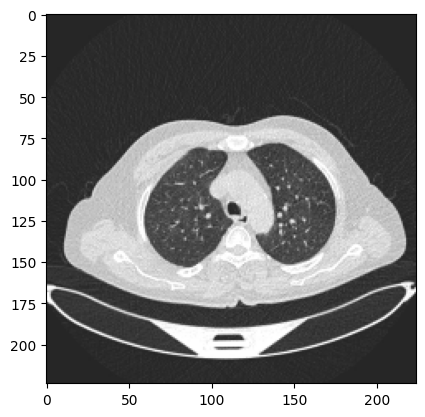

In [10]:
import matplotlib.pylab as plt
plt.imshow(X[10], cmap='gray')


In [11]:
# X[10]
np.max(X)

255

In [12]:
# import cv2
# window_name = 'Image'
# cv2.imshow(window_name, X[10])

In [13]:
X = [value / 255.0 for value in X]
X_val = [value / 255.0 for value in X_val]

x_train = np.array(X)
y_train = np.array(Y)

x_val = np.array(X_val)
y_val = np.array(Y_val)

In [14]:
np.max(x_train)

1.0

In [15]:
print(x_train.shape)
print(y_train.shape)

# print(x_val.shape)
# print(y_val.shape)

(1855, 224, 224, 3)
(1855,)


In [16]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_train,y_train, shuffle=True, test_size=0.1)

In [17]:
print(x_train.shape)
print(y_train.shape)

(1669, 224, 224, 3)
(1669,)


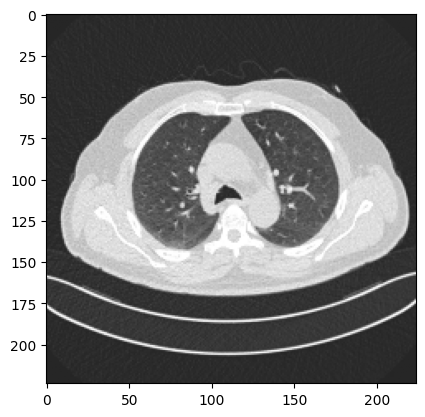

In [18]:
import matplotlib.pylab as plt
plt.imshow(X[4], cmap='gray')

In [19]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D,MaxPool2D, Dense, Conv2D, Normalization, BatchNormalization, Flatten, Dropout, Input, Activation, Concatenate, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow import keras

In [20]:
from keras.applications.vgg16 import VGG16
w ='/kaggle/input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_vgg16 = VGG16(
    include_top=False,
    weights= w,
    input_shape=(224,224,3),
    classifier_activation="relu",
)
for layer in base_vgg16.layers:
  layer.trainable = False

In [21]:
import tensorflow as tf
from tensorflow.keras import layers

def cbam_block(input_feature, ratio=8):
    # Channel Attention (CA) submodule
    x = input_feature
    batch, _, _, channel = x.shape
    
    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats_ca = x1 + x2
    feats_ca = Activation("sigmoid")(feats_ca)
    feats_ca = Multiply()([x, feats_ca])

    # Spatial Attention (SA) submodule
    ## Average Pooling
    y1 = tf.reduce_mean(feats_ca, axis=-1)
    y1 = tf.expand_dims(y1, axis=-1)

    ## Max Pooling
    y2 = tf.reduce_max(feats_ca, axis=-1)
    y2 = tf.expand_dims(y2, axis=-1)

    ## Concatenat both the features
    feats_sa = Concatenate()([y1, y2])
    ## Conv layer
    feats_sa = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats_sa)
    feats_sa = Multiply()([x, feats_sa])

    # Combine CA and SA
    cbam_feature = layers.Add()([feats_ca, feats_sa])

    return cbam_feature

In [22]:
x = base_vgg16.output
# x = Conv2D(256, (3,3), padding="same", activation="relu") (x)
# x = Conv2D(128, (3,3), padding="same", activation="relu") (x)
# x = GlobalMaxPooling2D() (x)
x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(4, activation = 'softmax') (x)
vgg_16_model = Model(base_vgg16.input, output)

vgg_16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
vgg_16_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [24]:
print("x shape:", x_train.shape)
print("y shape:", y_train.shape)
# print("x_val shape:", x_val.shape)
# print("y_val shape:", y_val.shape)

x shape: (1669, 224, 224, 3)
y shape: (1669,)


In [25]:
vgg16_history = vgg_16_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
42/42 [==============================] - 29s 298ms/step - loss: 0.8107 - accuracy: 0.7101 - val_loss: 0.5158 - val_accuracy: 0.8144
Epoch 2/20
42/42 [==============================] - 6s 146ms/step - loss: 0.3844 - accuracy: 0.8494 - val_loss: 0.2609 - val_accuracy: 0.8743
Epoch 3/20
42/42 [==============================] - 6s 145ms/step - loss: 0.1976 - accuracy: 0.9318 - val_loss: 0.1502 - val_accuracy: 0.9611
Epoch 4/20
42/42 [==============================] - 6s 147ms/step - loss: 0.1464 - accuracy: 0.9446 - val_loss: 0.1435 - val_accuracy: 0.9491
Epoch 5/20
42/42 [==============================] - 6s 148ms/step - loss: 0.0980 - accuracy: 0.9640 - val_loss: 0.0982 - val_accuracy: 0.9611
Epoch 6/20
42/42 [==============================] - 6s 147ms/step - loss: 0.0851 - accuracy: 0.9625 - val_loss: 0.0847 - val_accuracy: 0.9701
Epoch 7/20
42/42 [==============================] - 6s 148ms/step - loss: 0.0778 - accuracy: 0.9625 - val_loss: 0.0643 - val_accuracy: 0.9671
Epoch

In [26]:
vgg_16_model.evaluate(X_test,Y_test)

7/7 [==============================] - 4s 654ms/step - loss: 3.1692 - accuracy: 0.5748


[3.169151544570923, 0.5747663378715515]

In [27]:
p1 = []
for data in X_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = vgg_16_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p1.append(pred)
from sklearn.metrics import classification_report
print(classification_report(Y_test, p1))

p2 = []
for data in x_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = vgg_16_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p2.append(pred)
from sklearn.metrics import classification_report
print(classification_report(y_test, p2))

1/1 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       123
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        80

    accuracy                           0.57       214
   macro avg       0.19      0.33      0.24       214
weighted avg       0.33      0.57      0.42       214

1/1 [==============================] - 0s 25ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.93      0.97      0.95        72
           2       0.97      0.92      0.94        61

    accuracy                           0.96       186
   macro avg       0.97      0.96      0.96       186
weighted avg       0.96      0.96      0.96       186



In [28]:
x = cbam_block(base_vgg16.layers[-1].output)
x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(4, activation = 'softmax') (x)
vgg_16_cbam_model = Model(base_vgg16.input, output)

vgg_16_cbam_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [29]:
vgg_16_cbam_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [30]:
vgg16_cbam_history = vgg_16_cbam_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
42/42 [==============================] - 13s 179ms/step - loss: 0.7213 - accuracy: 0.7566 - val_loss: 0.3869 - val_accuracy: 0.8144
Epoch 2/20
42/42 [==============================] - 6s 154ms/step - loss: 0.2608 - accuracy: 0.9094 - val_loss: 0.1467 - val_accuracy: 0.9581
Epoch 3/20
42/42 [==============================] - 6s 155ms/step - loss: 0.1197 - accuracy: 0.9588 - val_loss: 0.1167 - val_accuracy: 0.9611
Epoch 4/20
42/42 [==============================] - 7s 156ms/step - loss: 0.0966 - accuracy: 0.9655 - val_loss: 0.0763 - val_accuracy: 0.9671
Epoch 5/20
42/42 [==============================] - 7s 157ms/step - loss: 0.0776 - accuracy: 0.9678 - val_loss: 0.0798 - val_accuracy: 0.9611
Epoch 6/20
42/42 [==============================] - 7s 157ms/step - loss: 0.0610 - accuracy: 0.9730 - val_loss: 0.1551 - val_accuracy: 0.9461
Epoch 7/20
42/42 [==============================] - 7s 157ms/step - loss: 0.0665 - accuracy: 0.9723 - val_loss: 0.0857 - val_accuracy: 0.9701
Epoch

In [31]:
vgg_16_cbam_model.evaluate(X_test,Y_test)

7/7 [==============================] - 1s 121ms/step - loss: 3.0666 - accuracy: 0.5748


[3.0666396617889404, 0.5747663378715515]

In [32]:
p = []
for data in X_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = vgg_16_cbam_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p.append(pred)
from sklearn.metrics import classification_report
print(classification_report(Y_test, p))

1/1 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       123
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        80

    accuracy                           0.57       214
   macro avg       0.19      0.33      0.24       214
weighted avg       0.33      0.57      0.42       214



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
p1 = []
for data in x_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = vgg_16_cbam_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p1.append(pred)
from sklearn.metrics import classification_report
print(classification_report(y_test, p1))

1/1 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.93      0.97      0.95        72
           2       0.97      0.92      0.94        61

    accuracy                           0.96       186
   macro avg       0.97      0.96      0.96       186
weighted avg       0.96      0.96      0.96       186



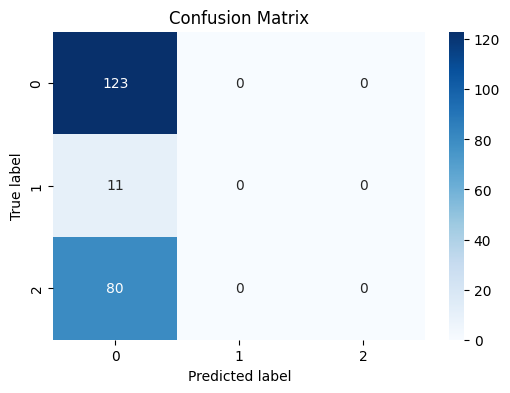

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(Y_test, p)

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['0','1','2'],
            yticklabels=['0','1','2'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

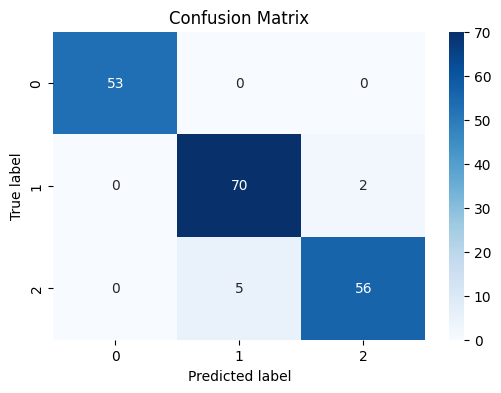

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(y_test, p1)

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['0','1','2'],
            yticklabels=['0','1','2'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

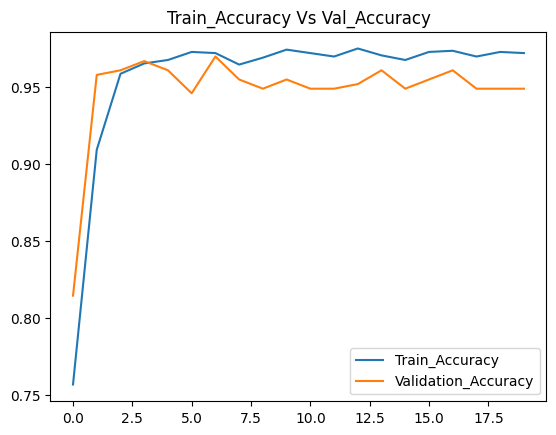

In [36]:
import matplotlib.pyplot as plt
plt.title('Train_Accuracy Vs Val_Accuracy')
plt.plot(vgg16_cbam_history.history['accuracy'], label='Train_Accuracy')
plt.plot(vgg16_cbam_history.history['val_accuracy'], label='Validation_Accuracy')
plt.legend()
plt.show();

In [37]:
# vgg_16_cbam_model.save('model-D2.h5')

In [38]:
# =====================================================================

In [39]:
from tensorflow.keras.models import load_model

ff_model = load_model('/kaggle/input/ff-model/bioInfo_modelV1.h5')

# ff_model.summary()

In [40]:
p2 = []
for data in X_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = ff_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p2.append(pred)
from sklearn.metrics import classification_report
print(classification_report(Y_test, p2))

1/1 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       123
           1       1.00      0.91      0.95        11
           2       1.00      0.95      0.97        80

    accuracy                           0.98       214
   macro avg       0.99      0.95      0.97       214
weighted avg       0.98      0.98      0.98       214



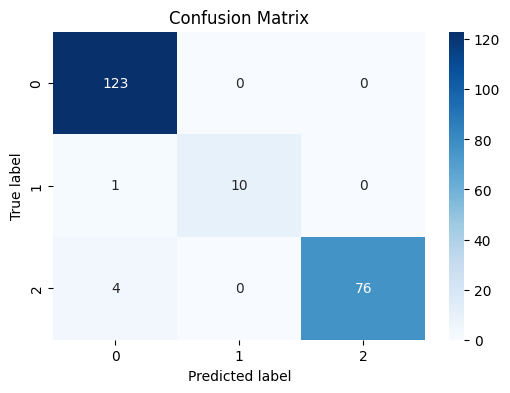

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(Y_test, p2)

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['0','1','2'],
            yticklabels=['0','1','2'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [42]:
import tensorflow as tf
w = '/kaggle/input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_InceptionV3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights= w,
    input_shape=(224,224,3),
    classifier_activation="relu",
)
for layer in base_InceptionV3.layers:
    layer.trainable = False

In [43]:
x = base_InceptionV3.output
x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(4, activation = 'softmax') (x)
InceptionV3_model = Model(base_InceptionV3.input, output)

InceptionV3_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d_1[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation_1 (Activation)   (None, 111, 111, 32)         0         ['batch_normalization[0]

In [44]:
InceptionV3_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [45]:
InceptionV3_history = InceptionV3_model.fit(x_train, y_train, batch_size = 32, epochs=20,validation_data = (x_val, y_val))

Epoch 1/20
53/53 [==============================] - 18s 190ms/step - loss: 1.0342 - accuracy: 0.6081 - val_loss: 0.7929 - val_accuracy: 0.8004
Epoch 2/20
53/53 [==============================] - 5s 90ms/step - loss: 0.6405 - accuracy: 0.7993 - val_loss: 0.4776 - val_accuracy: 0.8151
Epoch 3/20
53/53 [==============================] - 5s 90ms/step - loss: 0.4349 - accuracy: 0.8226 - val_loss: 0.3928 - val_accuracy: 0.8256
Epoch 4/20
53/53 [==============================] - 5s 91ms/step - loss: 0.3635 - accuracy: 0.8400 - val_loss: 0.3563 - val_accuracy: 0.8529
Epoch 5/20
53/53 [==============================] - 5s 91ms/step - loss: 0.3137 - accuracy: 0.8802 - val_loss: 0.3181 - val_accuracy: 0.8529
Epoch 6/20
53/53 [==============================] - 5s 91ms/step - loss: 0.2647 - accuracy: 0.8981 - val_loss: 0.3056 - val_accuracy: 0.8761
Epoch 7/20
53/53 [==============================] - 5s 90ms/step - loss: 0.2372 - accuracy: 0.9077 - val_loss: 0.2390 - val_accuracy: 0.9034
Epoch 8/20


In [46]:
p1 = []
for data in X_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = InceptionV3_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p1.append(pred)
from sklearn.metrics import classification_report
print(classification_report(Y_test, p1))

p2 = []
for data in x_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = InceptionV3_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p2.append(pred)
from sklearn.metrics import classification_report
print(classification_report(y_test, p2))

1/1 [==============================] - 0s 28ms/step
              precision    recall  f1-score   support

           0       0.70      1.00      0.83       123
           1       0.00      0.00      0.00        11
           2       1.00      0.25      0.40        80

    accuracy                           0.67       214
   macro avg       0.57      0.42      0.41       214
weighted avg       0.78      0.67      0.62       214

1/1 [==============================] - 0s 26ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.92      0.96      0.94        72
           2       0.95      0.90      0.92        61

    accuracy                           0.95       186
   macro avg       0.96      0.95      0.95       186
weighted avg       0.95      0.95      0.95       186



In [47]:
import tensorflow as tf
base_MobNetV2 = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights= "imagenet",
    input_shape=(224,224,3),
    classifier_activation="relu",
)
for layer in base_MobNetV2.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [48]:
x = base_MobNetV2.output

x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(3, activation = 'softmax') (x)
MobNet2_model = Model(base_MobNetV2.input, output)

MobNet2_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [49]:
MobNet2_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [50]:
MobNet2_model_history = MobNet2_model.fit(x_train, y_train, batch_size = 32, epochs=20,validation_data = (x_val, y_val))

Epoch 1/20
53/53 [==============================] - 11s 114ms/step - loss: 0.6549 - accuracy: 0.7579 - val_loss: 0.4028 - val_accuracy: 0.8382
Epoch 2/20
53/53 [==============================] - 3s 61ms/step - loss: 0.3512 - accuracy: 0.8502 - val_loss: 0.3030 - val_accuracy: 0.8697
Epoch 3/20
53/53 [==============================] - 3s 61ms/step - loss: 0.2711 - accuracy: 0.8886 - val_loss: 0.2223 - val_accuracy: 0.9286
Epoch 4/20
53/53 [==============================] - 3s 61ms/step - loss: 0.1909 - accuracy: 0.9341 - val_loss: 0.1534 - val_accuracy: 0.9433
Epoch 5/20
53/53 [==============================] - 3s 60ms/step - loss: 0.1371 - accuracy: 0.9521 - val_loss: 0.1520 - val_accuracy: 0.9370
Epoch 6/20
53/53 [==============================] - 3s 61ms/step - loss: 0.1156 - accuracy: 0.9587 - val_loss: 0.1257 - val_accuracy: 0.9517
Epoch 7/20
53/53 [==============================] - 3s 61ms/step - loss: 0.1053 - accuracy: 0.9545 - val_loss: 0.1170 - val_accuracy: 0.9391
Epoch 8/20


In [51]:
p1 = []
for data in X_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = MobNet2_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p1.append(pred)
from sklearn.metrics import classification_report
print(classification_report(Y_test, p1))

p2 = []
for data in x_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = MobNet2_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p2.append(pred)
from sklearn.metrics import classification_report
print(classification_report(y_test, p2))

1/1 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

           0       0.66      1.00      0.80       123
           1       0.00      0.00      0.00        11
           2       1.00      0.33      0.49        80

    accuracy                           0.70       214
   macro avg       0.55      0.44      0.43       214
weighted avg       0.76      0.70      0.64       214

1/1 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.95      0.96      0.95        72
           2       0.95      0.93      0.94        61

    accuracy                           0.96       186
   macro avg       0.97      0.96      0.96       186
weighted avg       0.96      0.96      0.96       186



In [52]:
base_ResNet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    classifier_activation="relu",
)

94765736/94765736 [==============================] - 0s 0us/step


In [53]:
x = base_ResNet50.output

x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(3, activation = 'softmax') (x)
ResNet50_model = Model(base_ResNet50.input, output)

ResNet50_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [54]:
ResNet50_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [55]:
ResNet50_model_history = ResNet50_model.fit(x_train, y_train, batch_size = 32, epochs=20,validation_data = (x_val, y_val))

Epoch 1/20
53/53 [==============================] - 61s 417ms/step - loss: 0.4915 - accuracy: 0.8316 - val_loss: 2.2323 - val_accuracy: 0.3067
Epoch 2/20
53/53 [==============================] - 18s 338ms/step - loss: 0.3076 - accuracy: 0.8904 - val_loss: 1.1708 - val_accuracy: 0.2983
Epoch 3/20
53/53 [==============================] - 18s 337ms/step - loss: 0.2581 - accuracy: 0.9047 - val_loss: 3.1747 - val_accuracy: 0.3067
Epoch 4/20
53/53 [==============================] - 18s 335ms/step - loss: 0.2565 - accuracy: 0.8916 - val_loss: 2.1728 - val_accuracy: 0.3067
Epoch 5/20
53/53 [==============================] - 18s 333ms/step - loss: 0.1646 - accuracy: 0.9383 - val_loss: 2.2405 - val_accuracy: 0.3067
Epoch 6/20
53/53 [==============================] - 18s 334ms/step - loss: 0.2889 - accuracy: 0.8766 - val_loss: 2.3581 - val_accuracy: 0.3067
Epoch 7/20
53/53 [==============================] - 18s 335ms/step - loss: 0.1209 - accuracy: 0.9485 - val_loss: 3.4553 - val_accuracy: 0.3067

In [56]:
p1 = []
for data in X_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = ResNet50_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p1.append(pred)
from sklearn.metrics import classification_report
print(classification_report(Y_test, p1))

p2 = []
for data in x_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = ResNet50_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p2.append(pred)
from sklearn.metrics import classification_report
print(classification_report(y_test, p2))

1/1 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       123
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        80

    accuracy                           0.57       214
   macro avg       0.19      0.33      0.24       214
weighted avg       0.33      0.57      0.42       214

1/1 [==============================] - 0s 24ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        53
           1       0.88      0.94      0.91        72
           2       1.00      0.85      0.92        61

    accuracy                           0.93       186
   macro avg       0.94      0.93      0.93       186
weighted avg       0.93      0.93      0.93       186

